# Experiments with NICE, Real NVP

## Target distribution

We will construct a distribution for two dimensional random variable $X$ that is a mixture of two distributions:
- $Z$ - a standard normal distribution
- $K$ - a uniform distribution on a rectangle

The X is as follows
$$
X = \delta Z + (1-\delta)K
$$
where $\delta$ is a random variable such that $P(\delta = 1) = p_{\delta} = 1 - P(\delta = 0)$. So $p_{\delta}$ is a probability of X being drawn from normal distrubution instead of from rectangle.
In this example I chose rectangle $[0.5, 3] \times [1,3]$. 

During this series of experiments we will estimate probability that both coordinates of $X$ is greater than $t$. We can calculate exact value of this probability as
$$
P(x_1>t)^2 p_{\delta} + P(X \in K_t)*(1 - p_\delta)
$$
where K_t is a rectangle restricted by $t$: $K_t \{(x_1, x_2) \in [a, b] \times [c, d]: x_1>t, x_2 >t\}$.

In [3]:
import matplotlib.pyplot as plt
from utils import *

torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

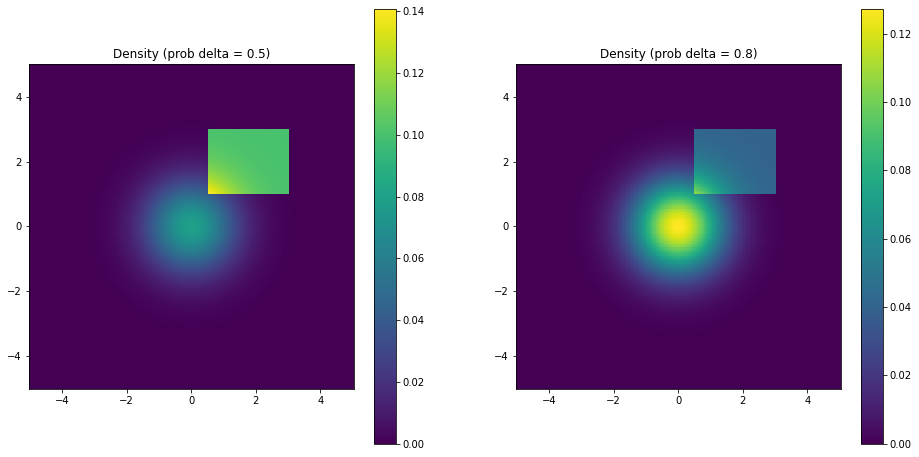

In [132]:
# Plot distribution

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(x_dim = 2, prob_delta=0.5, K_intervals=K_intervals)
prob = nu.calculate_pdf(zz)[:, None].reshape(200, 200)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
c=plt.pcolormesh(xx, yy, prob, shading='auto')
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.title("Density (prob delta = 0.5)")

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(x_dim = 2, prob_delta=0.8, K_intervals=K_intervals)
prob = nu.calculate_pdf(zz)[:, None].reshape(200, 200)

plt.subplot(1, 2, 2)
c=plt.pcolormesh(xx, yy, prob, shading='auto')
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')
plt.title("Density (prob delta = 0.8)")
plt.show()

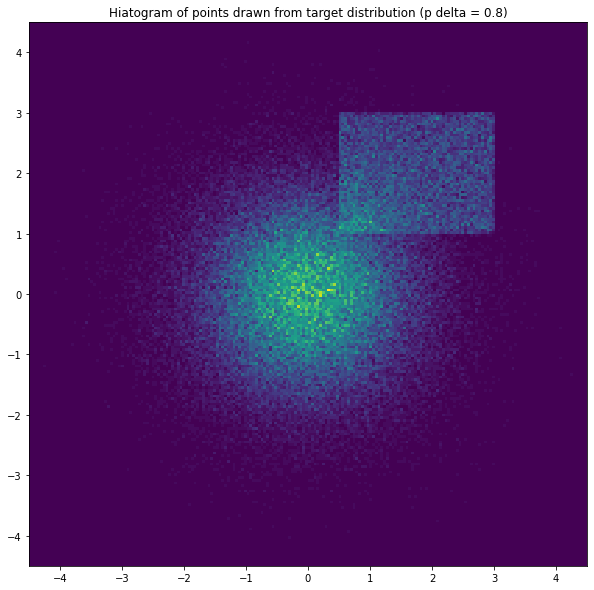

In [133]:
x_np = nu.forward(100000)[0].numpy()
plt.figure(figsize=(10, 10))
plt.hist2d(x_np[:, 0], x_np[:, 1], bins=200, range=[[-4.5, 4.5], [-4.5, 4.5]])
plt.title("Hiatogram of points drawn from target distribution (p delta = 0.8)")
plt.show()

## NICE
In this experiment we will calculate coupling transformations as follows
$$
y_1 = x_1 \\
y_2 = x_2 + t(x_1)
$$
where t is a dense neural network. At the end of these transformation we apply scaling by 
$\exp(s)$ of the whole vector (both dimensions). 
Logarithm of Jacobian of this transformation is $1+ dim_x \cdot s$
The inverse transformation of each coupling layer is then as follows
$$
x_1 = y_1 \\
x_2 = y_2 - t(y_1)
$$

Base distribution is 2 dimensional Gaussian distribution with independent variables - $N(0, I)$.

We will provide parameters:
- prob_delta - $p_\delta$ which indicates the probability of normal distribution in the mixture
- num_segments - number of coupling layers
- max_iter - number of iterations in the training loop
- num_samples - number of ssamples from the target distribution that the model will be learning on
- dims_dense - dimensions of dense neural network $t$

In [134]:
# Parameters
prob_delta = 0.5
num_segments = 6
max_iter = 2000
num_samples = 2048
dims_dense =[1, 16, 64, 16, 1]

In [135]:
#Distribution

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

  0%|          | 0/2000 [00:00<?, ?it/s]

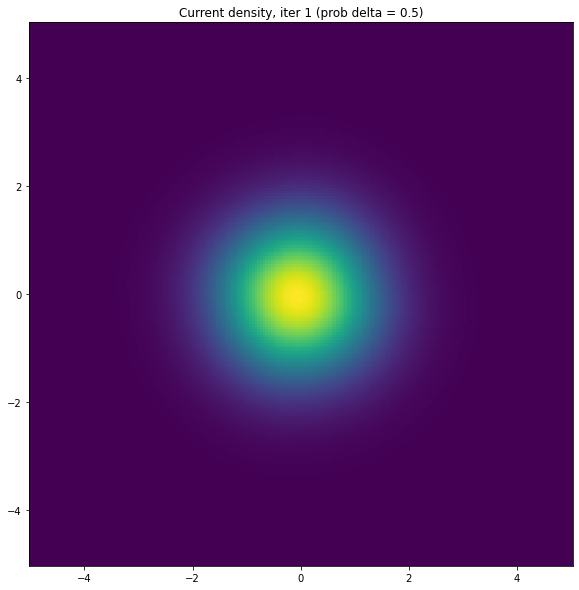

 12%|█▏        | 246/2000 [00:09<01:05, 26.64it/s]

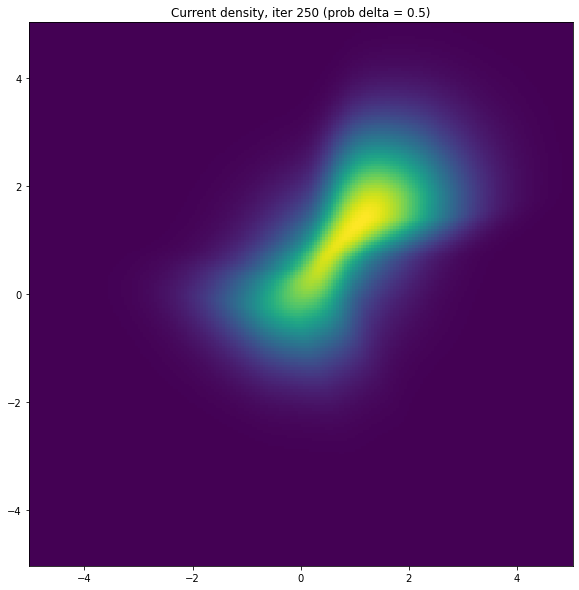

 25%|██▍       | 496/2000 [00:17<00:43, 34.25it/s]

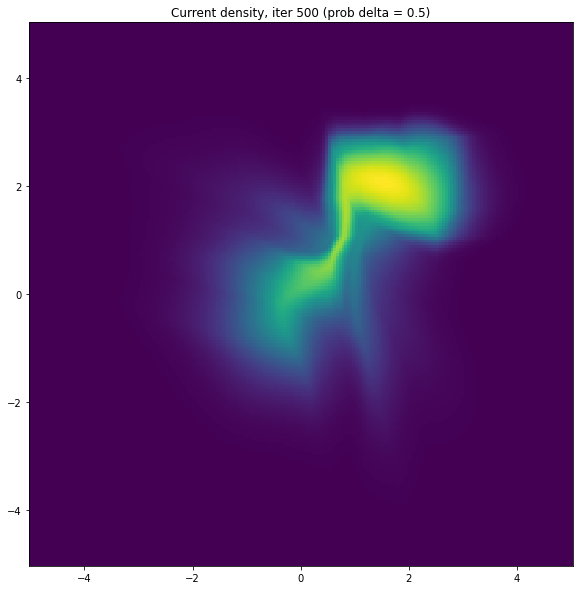

 37%|███▋      | 749/2000 [00:27<00:35, 35.33it/s]

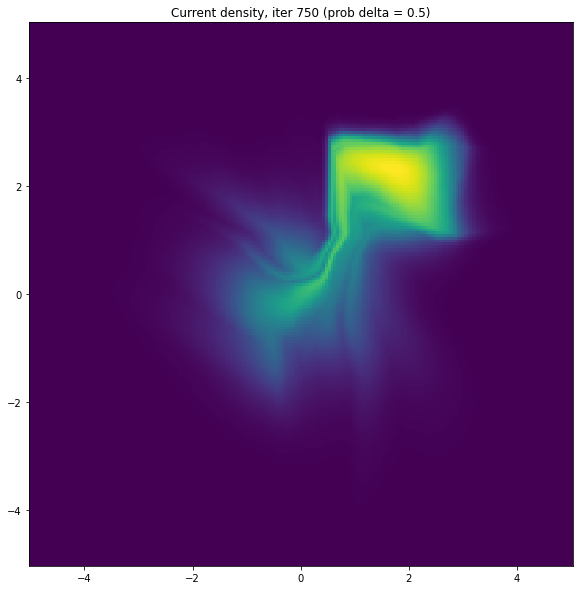

 50%|████▉     | 998/2000 [00:36<00:46, 21.77it/s]

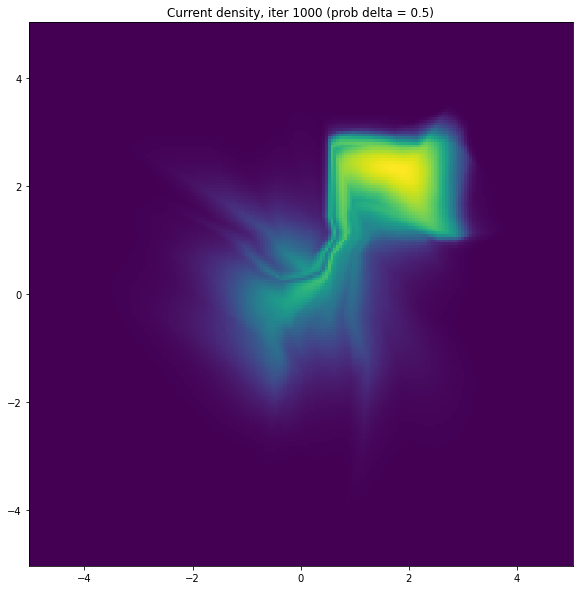

 62%|██████▏   | 1247/2000 [00:44<00:26, 28.39it/s]

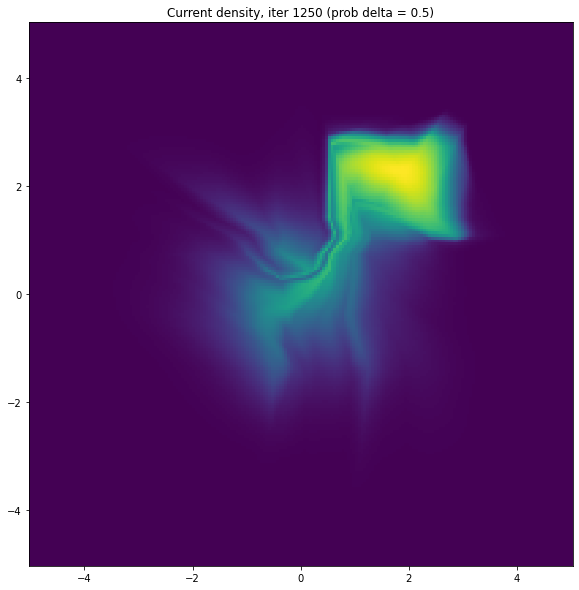

 75%|███████▍  | 1498/2000 [00:53<00:20, 24.64it/s]

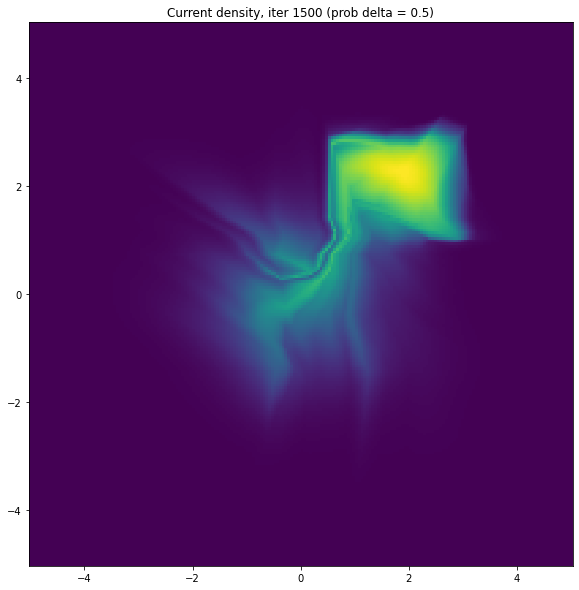

 87%|████████▋ | 1746/2000 [01:04<00:07, 33.28it/s]

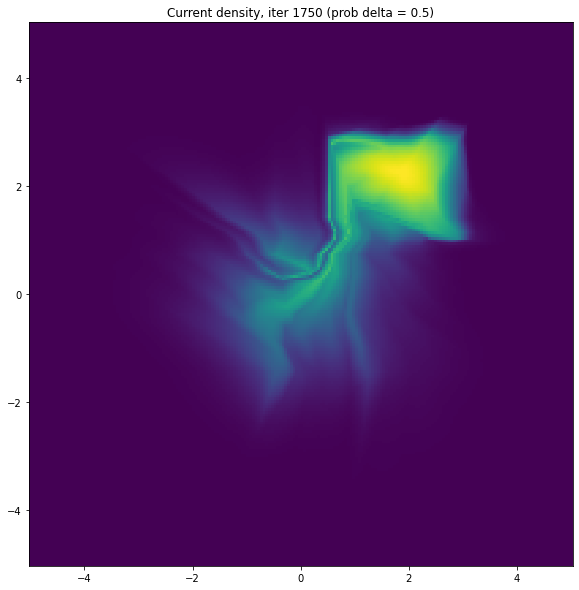

100%|█████████▉| 1998/2000 [01:19<00:00, 30.80it/s]

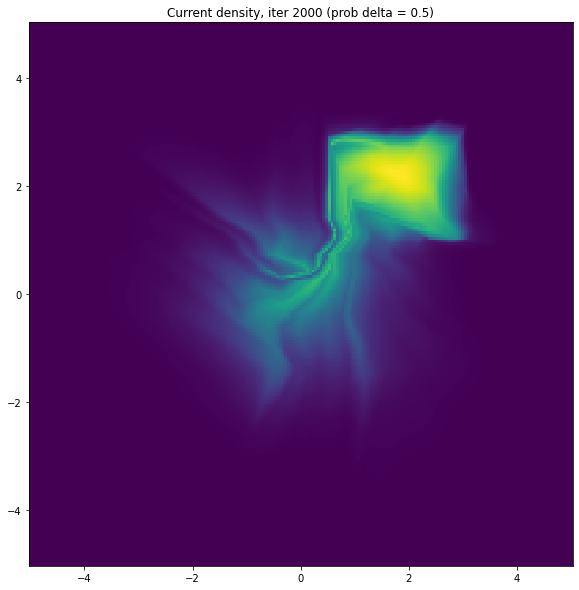

100%|██████████| 2000/2000 [01:20<00:00, 24.89it/s]


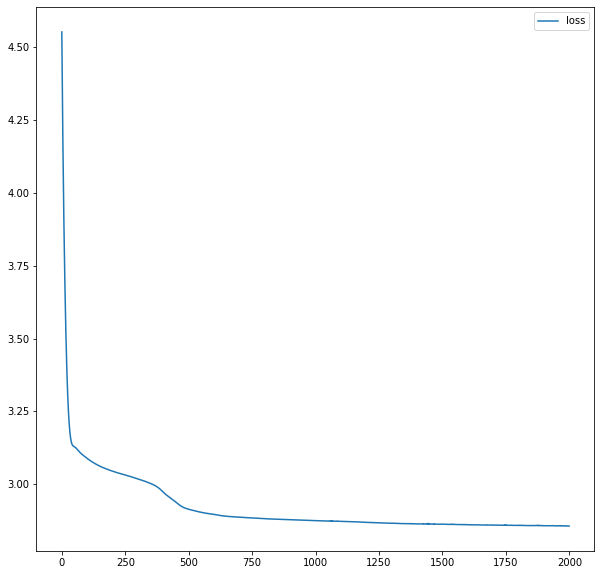

In [136]:
# Creating model

base = nf.distributions.base.DiagGaussian(2)
flows = []
for i in range(num_segments):
    flows += [AffineSingleBlock(SimpleDenseCustDim(dims_dense))]
    flows += [Swap()]

flows += [ScalingBlock(dim_x = 2)]
model = MyNormFlow(q0 = base, flows = flows)

show_iter = int(max_iter/8)

loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

# Get training samples
x_np = nu.forward(num_samples)[0].numpy()
x = torch.tensor(x_np).float()

# Training loop
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    #error prob
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0 or it==0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        fig = plt.figure(figsize=(10, 10))
        plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
        plt.gca().set_aspect('equal', 'box')
        plt.title(f"Current density, iter {it+1} (prob delta = {prob_delta})")
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [137]:
import pandas as pd

t_array = np.arange(0, 3.01, 0.1)
true_probs = []
cmc_2048 = []
cmc_4096 = []
cmc_10000 = []

# Calculating true value of P(X>t)
for t_float in t_array:
    t = torch.tensor(t_float)
    true_probs.append(nu.prob_greater_t(t).item())

dict_estims = {'t':t_array, 'true_probs':true_probs}

for nums_s in [2048, 4096, 10000]:
    cmc_list = []
    strat_list = []
    for t_float in t_array:
        cmc_list.append(estim_prob_greater_t(model, R = nums_s, t_float=t_float))
        samples_strat = generate_samples_from_model_stratified(model, 20000, m=4, n = 2,verbose=False)['samples']
        strat_list.append(calc_prob_greater_t(samples_np=samples_strat, t_float=t_float))
    
    dict_estims[f'cmc_{nums_s}'] = cmc_list.copy()
    dict_estims[f'strat_{nums_s}'] = strat_list.copy()

estim_df = pd.DataFrame(dict_estims)

In [138]:
estim_df.head()

,t,true_probs,cmc_2048,strat_2048,cmc_4096,strat_4096,cmc_10000,strat_10000
0,0.0,0.625000,0.652344,0.63705,0.626465,0.63275,0.6460,0.63005
1,0.1,0.605879,0.618652,0.61250,0.612793,0.61340,0.6173,0.61525
2,0.2,0.588511,0.599121,0.60095,0.588867,0.60030,0.5970,0.60030
3,0.3,0.572996,0.582031,0.58175,0.578369,0.58435,0.5857,0.58595
4,0.4,0.559367,0.596680,0.57245,0.565430,0.56840,0.5700,0.57110


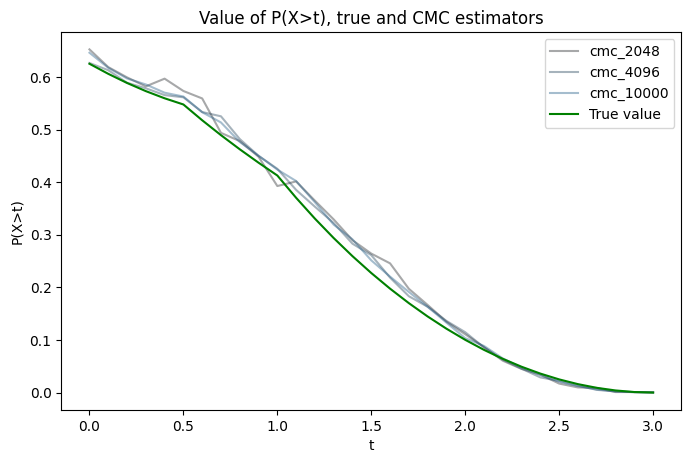

In [139]:
import seaborn as sns
python_blue = '#1F77B4'
palette = list(sns.dark_palette(python_blue, 4).as_hex())

plt.figure(figsize=(8, 5),  dpi=100)
for i, c in enumerate([col for col in estim_df.columns if 'cmc' in col]):
    plt.plot(estim_df['t'], estim_df[c], c=palette[i], label=c, alpha = 0.4)
plt.plot(estim_df['t'], estim_df['true_probs'], c='green', label = 'True value')
plt.title("Value of P(X>t), true and CMC estimators")
plt.xlabel('t')
plt.ylabel('P(X>t)')
plt.legend()
plt.show()


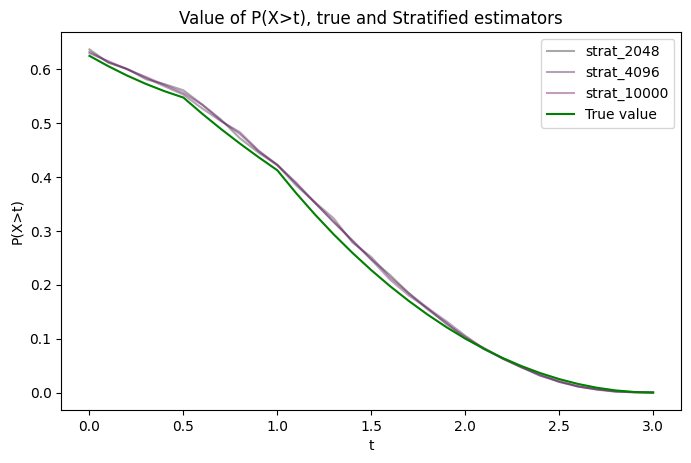

In [140]:
import seaborn as sns
python_blue = '#1F77B4'
palette = list(sns.dark_palette('purple', 4).as_hex())

plt.figure(figsize=(8, 5),  dpi=100)
for i, c in enumerate([col for col in estim_df.columns if 'strat' in col]):
    plt.plot(estim_df['t'], estim_df[c], c=palette[i], label=c, alpha = 0.4)
plt.plot(estim_df['t'], estim_df['true_probs'], c='green', label = 'True value')
plt.title("Value of P(X>t), true and Stratified estimators")
plt.xlabel('t')
plt.ylabel('P(X>t)')
plt.legend()
plt.show()

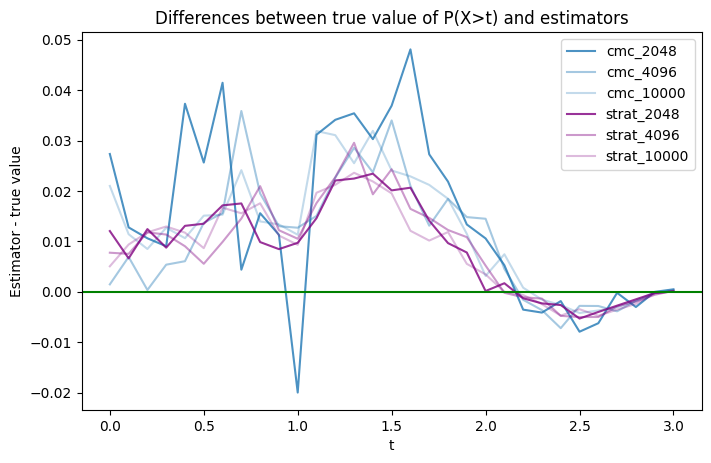

In [141]:
differences = estim_df.drop(['t','true_probs'], axis=1).sub(estim_df['true_probs'], axis=0)

plt.figure(figsize=(8, 5),  dpi=100)
for i, c in enumerate([col for col in estim_df.columns if 'cmc' in col]):
    plt.plot(estim_df['t'], differences[c], c=python_blue, label=c, alpha = 0.8* 1/(i+1))
for i, c in enumerate([col for col in estim_df.columns if 'strat' in col]):
    plt.plot(estim_df['t'], differences[c], c='purple', label=c, alpha = 0.8* 1/(i+1))
#plt.plot(estim_df['t'], estim_df['true_probs'], c='green', label = 'True value')
plt.title("Differences between true value of P(X>t) and estimators")
plt.axhline(0, c='green')
plt.xlabel('t')
plt.ylabel('Estimator - true value')
plt.legend()
plt.show()


Here it shows hav the model looks with stratified sampling, based on stratas from base distribution - standard normal.

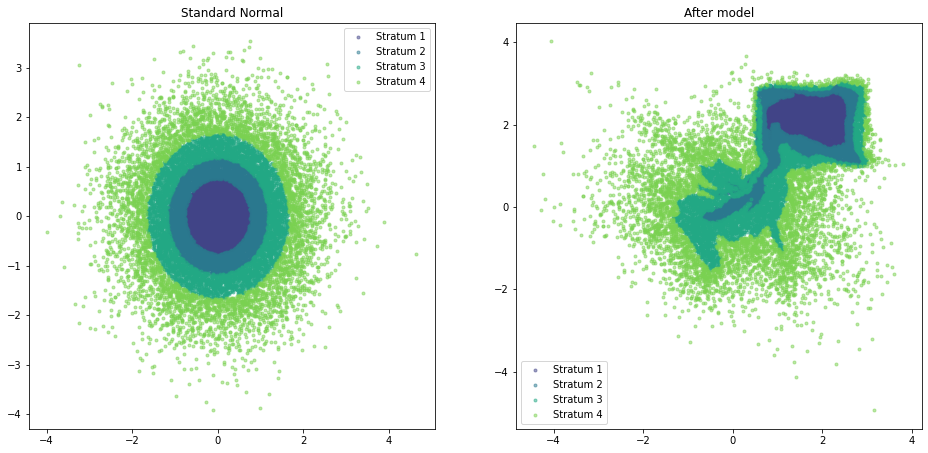

In [142]:
generate_samples_from_model_stratified(model, 20000, m=4, n = 2,verbose=True)

## RealNVP
Another experiment with different architecture. This time each coupling layer will be calculated as
$$
y_1 = x_1 \\
y_2 = x_2 \cdot \exp(s(x_1)) + t(x_1)
$$
where $t$ is as before, dense neural network and $s$ is also dense neural network (not as before - only scalar). Logarith of Jacobian of each coupling layer is $1 + \sum s_i$
The inverse transformation is as follows:
$$
x_1 = y_1 \\
x_2 = (y_2 - t(y_1)) \cdot \exp(-s(y_1))
$$
with logarithm of Jacobian $1 - \sum s_i$.

In [143]:
# Parameters
prob_delta = 0.5
num_segments = 6
max_iter = 2000
num_samples = 2048
dims_dense_t =[1, 4, 1]
dims_dense_s =[1, 4, 1]

In [144]:
#Distribution

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

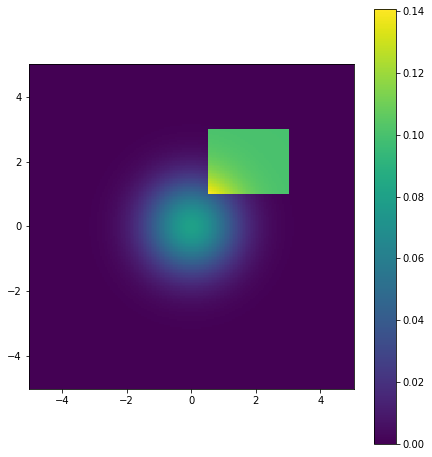

In [145]:
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

prob = nu.calculate_pdf(zz)[:, None].reshape(200, 200)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
c=plt.pcolormesh(xx, yy, prob, shading='auto')
plt.colorbar(c)
plt.gca().set_aspect('equal', 'box')

  0%|          | 0/2000 [00:00<?, ?it/s]

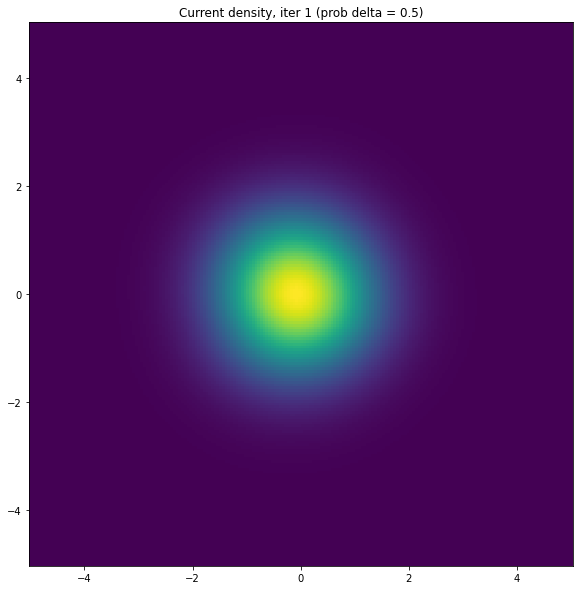

 12%|█▏        | 239/2000 [00:01<00:09, 190.02it/s]

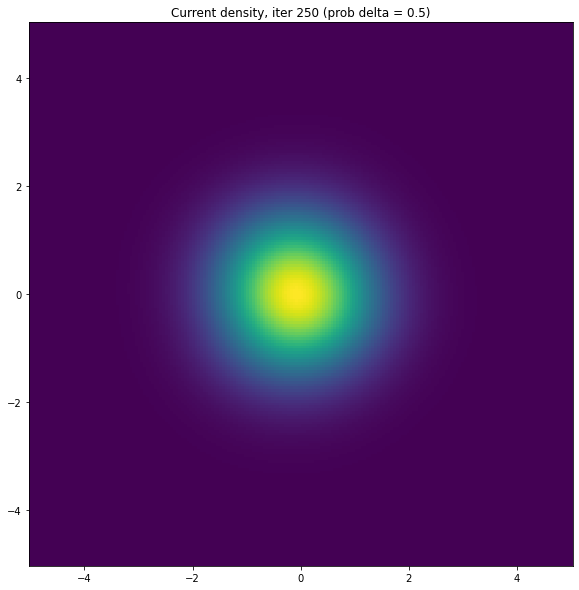

 24%|██▍       | 480/2000 [00:03<00:07, 191.15it/s]

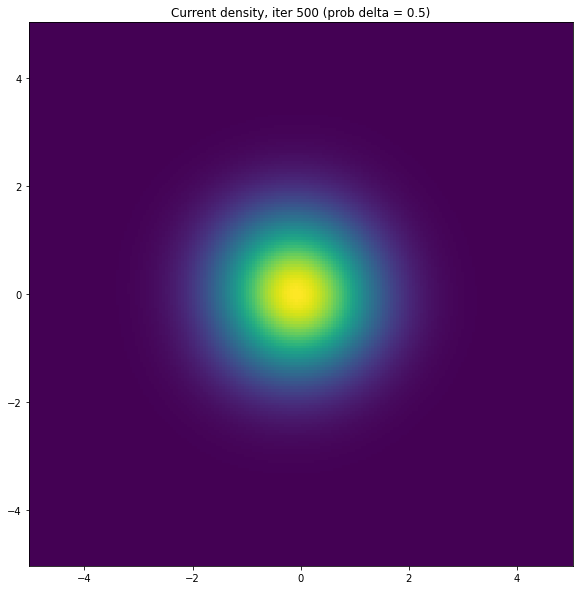

 37%|███▋      | 748/2000 [00:05<00:08, 149.23it/s]

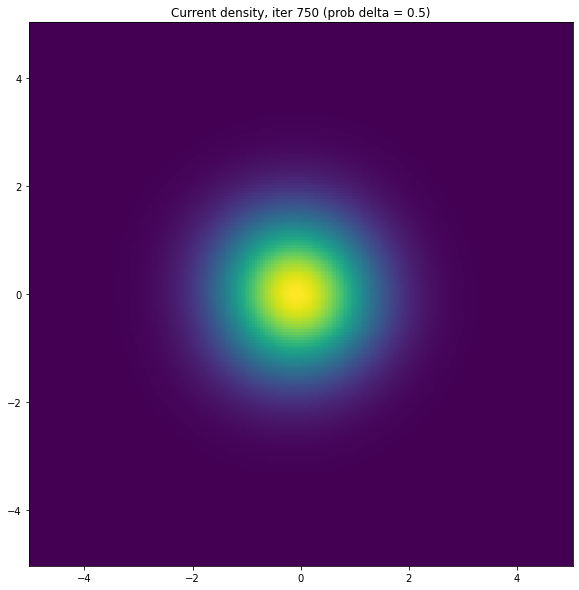

 49%|████▉     | 984/2000 [00:06<00:05, 188.61it/s]

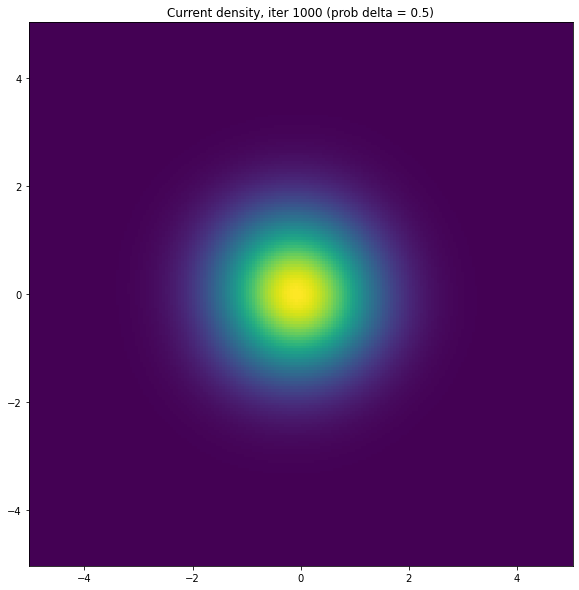

 62%|██████▏   | 1233/2000 [00:08<00:03, 202.74it/s]

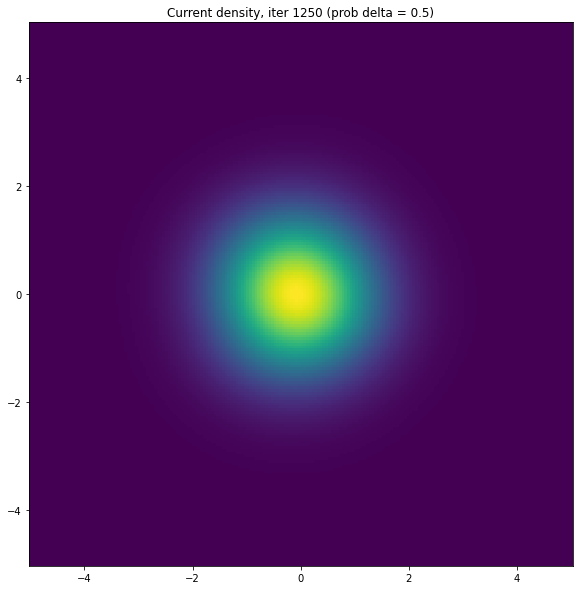

 75%|███████▍  | 1497/2000 [00:09<00:02, 212.92it/s]

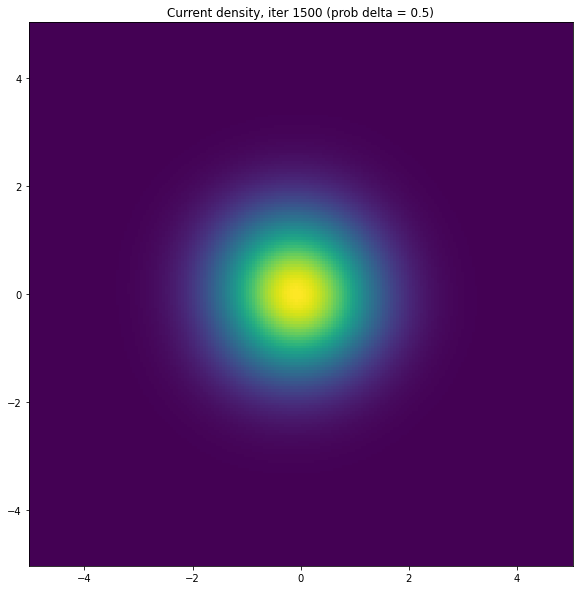

 87%|████████▋ | 1741/2000 [00:11<00:01, 131.84it/s]

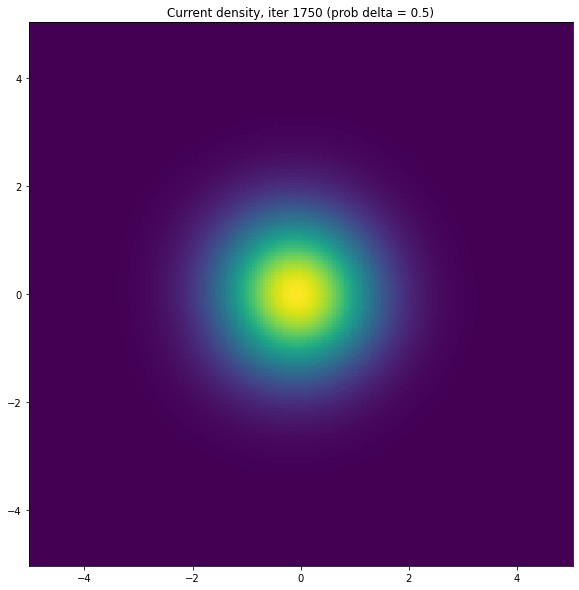

 99%|█████████▉| 1986/2000 [00:13<00:00, 199.22it/s]

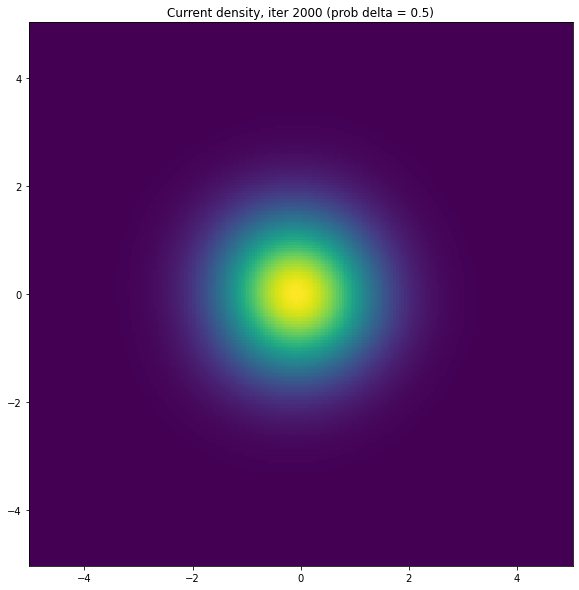

100%|██████████| 2000/2000 [00:13<00:00, 144.24it/s]


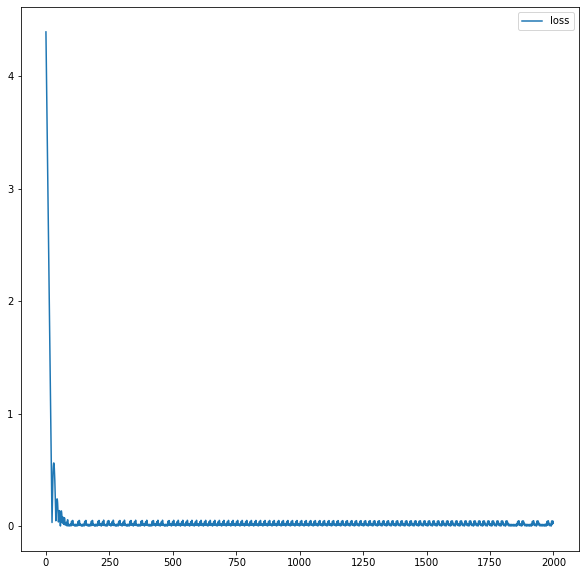

In [146]:
# Creating model
max_iter = 2000
num_segments = 1

base = nf.distributions.base.DiagGaussian(2)
flows = []
for i in range(num_segments):
    flows += [RealNVPBlock(param_net_s=SimpleDenseCustDim(dims=dims_dense_s, init_zeros=True), 
                           param_net_t=SimpleDenseCustDim(dims=dims_dense_t))]
    flows += [Swap()]

model = MyNormFlow(q0 = base, flows = flows)

show_iter = int(max_iter/8)

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

# Get training samples
x_np = nu.forward(num_samples)[0].numpy()
x = torch.tensor(x_np).float()

# Training loop
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    #error prob
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0 or it==0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        fig = plt.figure(figsize=(10, 10))
        plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
        plt.gca().set_aspect('equal', 'box')
        plt.title(f"Current density, iter {it+1} (prob delta = {prob_delta})")
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()